Here I will have some examples showing how to use Sampyl. This is for version 0.1. Let's import it and get started. Sampyl is a Python package used to sample from probability distributions. This is most useful when sampling from the posterior distribution of a Bayesian model.

Every sampler provided by Sampyl works the same way. Define $ \log P(\theta) $ as a function, then pass it to the sampler class. The class returns a sampler object, which you can then use to sample from $P(\theta)$. For samplers which use $\nabla_{\theta} \log P(\theta)$, Sampyl uses [autograd](https://github.com/HIPS/autograd) to automatically calculate the gradients. However, you can pass in your own $\nabla_{\theta} \log P(\theta)$ functions.

Starting out simple, let's sample from a normal distribution.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import sampyl as smp
from sampyl import np

In [2]:
mu, sig = 3, 2
def logp(x):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(sig**2) - np.sum((x - mu)**2)/(2*sig**2)

First we'll use a Metropolis-Hastings sampler.

In [3]:
start = {'x': 1.}
metro = smp.Metropolis(logp, start)
trace = metro.sample(10000, burn=2000, thin=4)

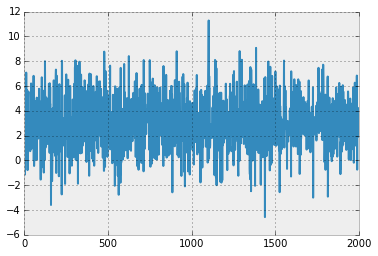

In [4]:
plt.plot(trace.x)

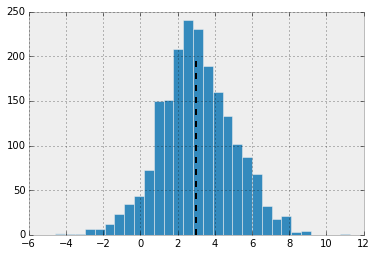

In [5]:
_ = plt.hist(trace.x, bins=30)
_ = plt.vlines(mu, 0, 200, linestyles='--')

There is also a No-U-Turn Sampler (NUTS), which avoids the random-walk nature of Metropolis samplers.

In [6]:
start = {'x': 1.}
nuts = smp.NUTS(logp, start)
trace = nuts.sample(1000)

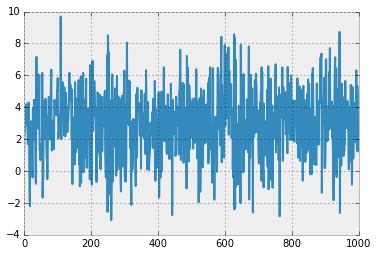

In [7]:
plt.plot(trace)

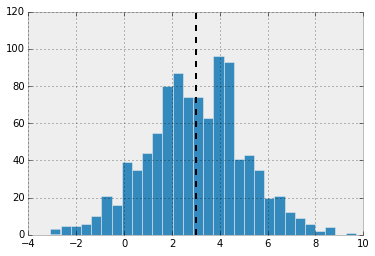

In [8]:
_ = plt.hist(trace.x, bins=30)
_ = plt.vlines(mu, 0, 120, linestyles='--')

Let's try something a little more complicated. Let's say you run a business and you put an advertisement in the paper. Then, to judge the effectiveness of the ad, you want to compare the number of incoming phone calls per hour before and after the placement of the add. Then we can build a simple model using a Poisson likelihood.


\begin{align}
P(\lambda_1, \lambda_2 \mid D) &\propto P( D \mid \lambda_1, \lambda_2)\, P(\lambda_1)\, P(\lambda_2) \\
P( D \mid \lambda_1, \lambda_2) &\sim \mathrm{Poisson}(D\mid\lambda_1)\,\mathrm{Poisson}(D\mid\lambda_2) \\
P(\lambda_1) &\sim \mathrm{Exp}(1) \\
P(\lambda_2) &\sim \mathrm{Exp}(1) 
\end{align}


In [9]:
# Fake data for the day before and after placing the ad
before = np.random.poisson(7, size=12)
after = np.random.poisson(9, size=12)
def logp(lam1, lam2):
    # Rates for Poisson must be > 0
    if lam1 <= 0 or lam2 <=0:
        return -np.inf
    else:
        # logps for likelihoods
        llh1 = np.sum(before*np.log(lam1)) - before.size*lam1
        llh2 = np.sum(after*np.log(lam2)) - after.size*lam2
        
        # Exponential priors for lams
        lam1_prior = -lam1
        lam2_prior = -lam2
        return llh1 + llh2 + lam1_prior + lam2_prior

In [10]:
start = {'lam1':1., 'lam2':1.}
metro = smp.Metropolis(logp, start)
trace = metro.sample(10000, burn=2000, thin=4)

Sampling returns a numpy record array which you can use to access samples by name. Variable names are taken directly from the argument list of `logp`.

In [11]:
print(metro.var_names)

('lam1', 'lam2')


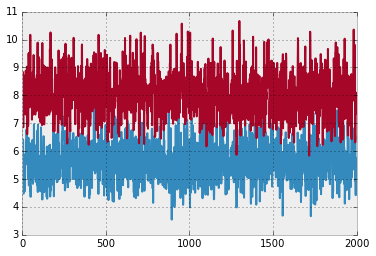

In [12]:
plt.plot(trace.lam1)
plt.plot(trace.lam2)

Now to see if there is a significant difference between the two days. We can find the difference $\delta =  \lambda_2 - \lambda_1$, then find the probability that $\delta > 0$.

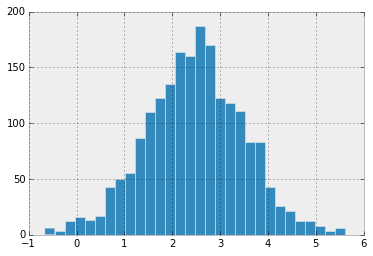

In [13]:
delta = trace.lam2 - trace.lam1
_ = plt.hist(delta, bins=30)

In [14]:
p = np.mean(delta > 0)
print("{:.3f} probability the rate of phone calls increased".format(p))

0.989 probability the rate of phone calls increased


/Users/mat/Envs/sampyl/lib/python3.4/site-packages/autograd/core.py:39: UserWarning: Output seems independent of input. Returning zero gradient.
  warnings.warn("Output seems independent of input. Returning zero gradient.")


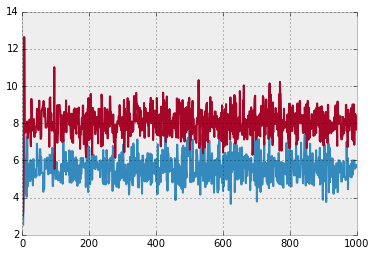

In [15]:
start = {'lam1': 1., 'lam2': 1.}
nuts = smp.NUTS(logp, start)
trace = nuts.sample(1000)
_ = plt.plot(trace.lam1)
_ = plt.plot(trace.lam2)

0.998 probability the rate of phone calls increased


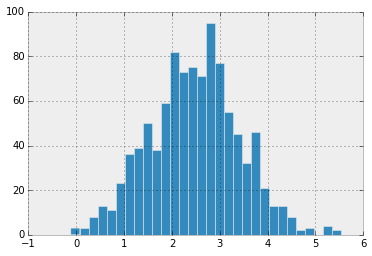

In [16]:
delta = trace.lam2 - trace.lam1
_ = plt.hist(delta, bins=30)
p = np.mean(delta > 0)
print("{:.3f} probability the rate of phone calls increased".format(p))

NUTS works as well!

When you build larger models, it would be cumbersome to have to include every parameter as an argument in the logp function. To avoid this, you can declare the size of variables when passing in the starting state.

For instance, with a linear model it would be great to pass the coefficients as one parameter. First, we'll make some fake data, then infer the coefficients.

In [17]:
N = 200
# True coefficients
true_B = np.array([1,2,3,4,5])

# Features
X = np.ones((N,5))
X[:,:-1] = np.random.rand(N, 4)

# Outcomes
y = np.dot(X, true_B) + np.random.randn(len(X))

In [18]:
from sampyl.priors import bound, prior_map, uniform

In [19]:
# Here, b is a length 5 array of coefficients
def logp(b, sig):
    n = len(y)
    y_hat = np.dot(X, b)
    likelihood = -n*0.5*np.log(2*np.pi) - \
                  n*0.5*np.log(sig**2) - \
                  np.sum((y - y_hat)**2)/(2*sig**2)
    
    # Jeffrey's prior for sigma, and bound it to > 0
    prior_sig = bound(-np.log(sig), sig > 0)
    
    # Uniform priors on coefficients
    prior_b = prior_map(uniform, b, lower=-5, upper=10).sum()
    
    return likelihood + prior_sig + prior_b

In [20]:
start = {'b': np.ones(5), 'sig': 1.}
metro = smp.Metropolis(logp, start)
trace = metro.sample(20000, burn=5000, thin=4)

/Users/mat/Envs/sampyl/lib/python3.4/site-packages/autograd/core.py:108: RuntimeWarning: invalid value encountered in log
  result = self.fun(*argvals, **kwargs)


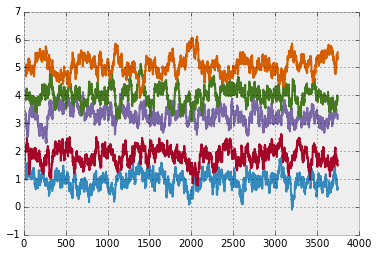

In [21]:
_ = plt.plot(trace.b)

And using NUTS too.

In [22]:
start = {'b': np.ones(5), 'sig': 1.}
nuts = smp.NUTS(logp, start)
trace = nuts.sample(1000, burn=50)

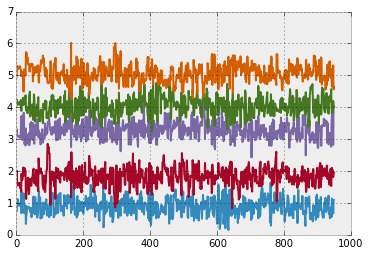

In [23]:
_ = plt.plot(trace.b)

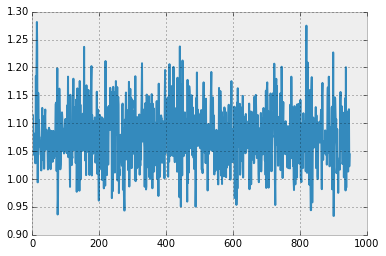

In [24]:
_ = plt.plot(trace.sig)

The future
----------

* Write a module that makes it easier to build logp functions from distributions
* Add various functions such as autocorrelation, HPD, etc.
* Slice sampler!
* A function to find the MAP for use as a starting state.
* Plots!